# Introduction to Time Series

Time series is a series of data points indexed based on time such as stock price, weather data, rainfall measurements, heart rate monitoring, sensor data and so on.    Generally, time space are equal but it can be change depend on your data and problem. Here are some of time series examples:

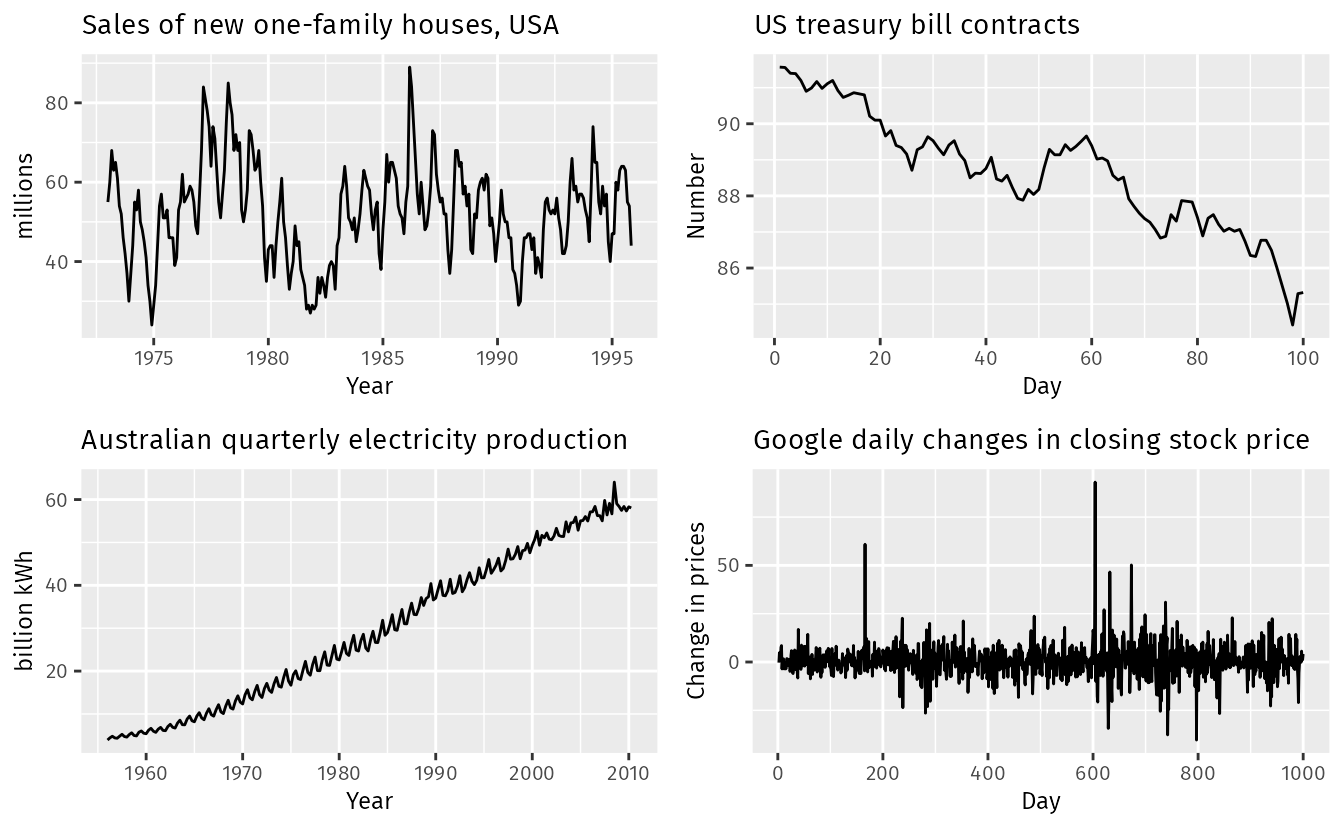


## Fundamentals of time series

### Stationary

Stationary series is a series that its statistical properties don't vary at the time. This statistical properties are mean, variance, covariance and standard deviation and not the function of time. Here is a series example of stationary and non-stationary series.

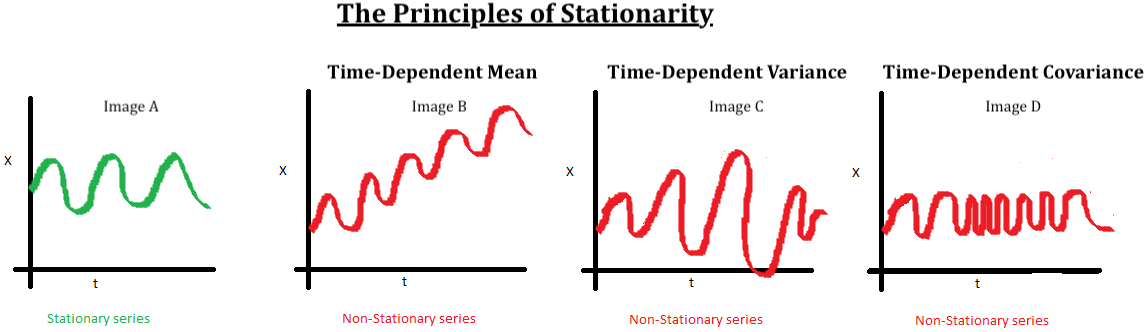

### Trend

Trend is a pattern in the data and show the movements in the long period. The movement direction might be on the up or down direction. In the below example, you can see the different type of trends such as linear, quadratic and cubic trends.

1. Linear trend: A linear trend represents a straight-line relationship between two variables. Equation of linear trends is `y=mx+b`
2. Quadratic trend: A quadratic trend represents a curved relationship between two variables. Equation of quadratic trends is `y=ax^2+bx+c`
3. Cubic trend: A cubic trend represents a more complex, S-shaped or curved relationship between two variables. Equation of cubic trends is `y=ax^3+bx^2+cx+d`

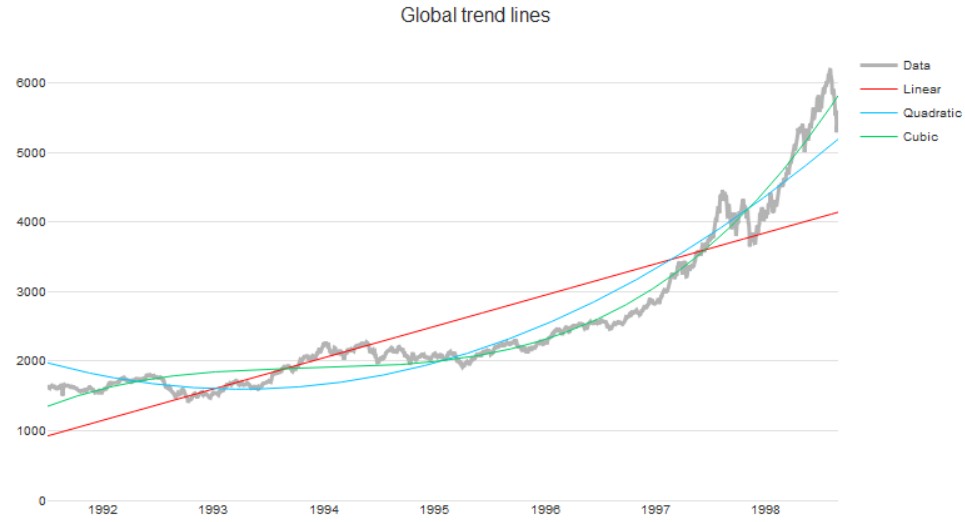

### Seasonality

Seasonality refers to a patern of data points that occurs at regular intervals time. This regular time can be days, weeks, months or seasons.

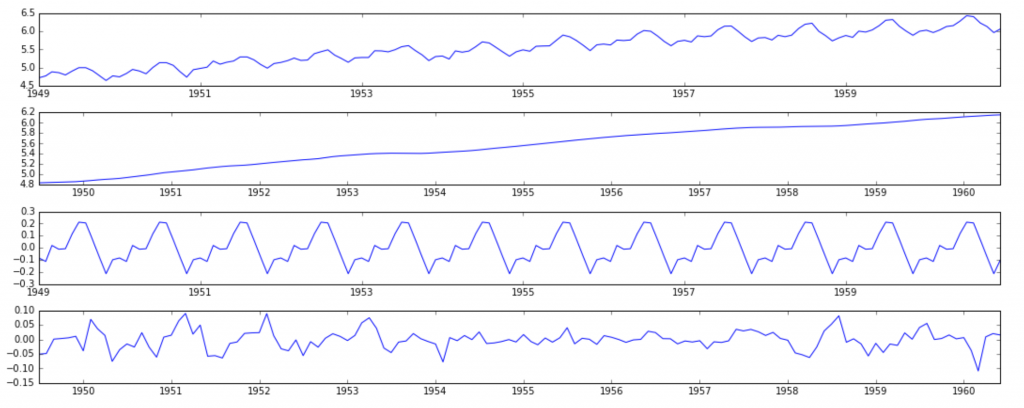

### Cycle

Cycle is a repeating pattern in the data that occurs over a fixed period of time. These cycles can be of varying lengths and are often associated with economic, environmental, or other natural phenomena.

### Moving Average

The future value of time series is average of k previous values. The formula of the moving average:

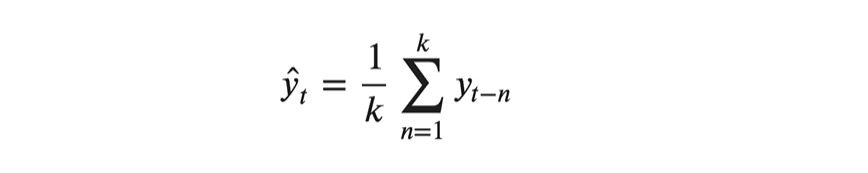

In the below graph, we compared the actual and moving average values for window size 4. (k=4)

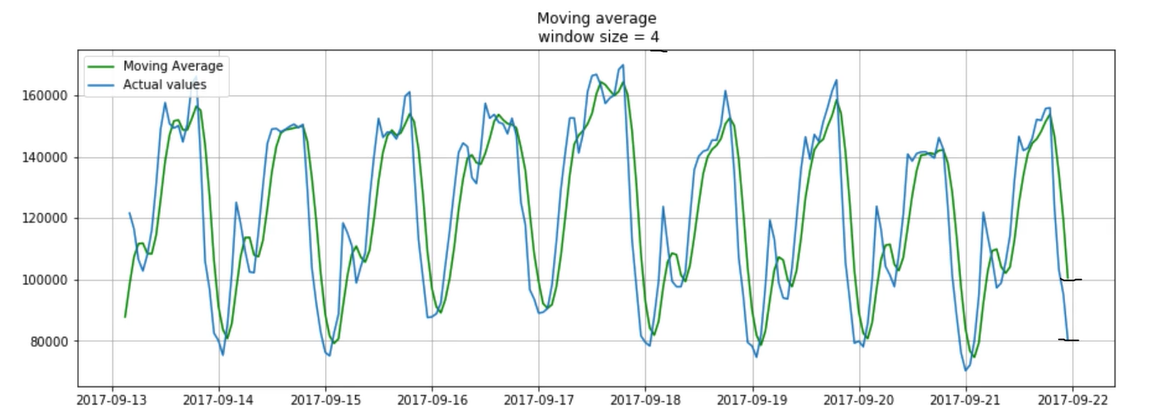

Let's increase the window size to 12 and see what happens..

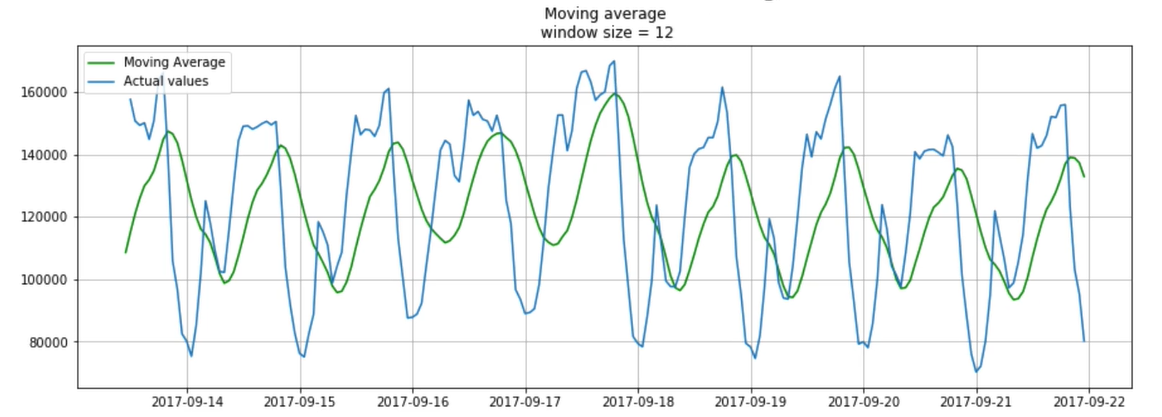

It looks like increasing the window size doesn't give us better results. Our moving average values are far from the actual values according to before window size.

### Weighted Average

Weighted average looks like moving average however there is a little difference that we give more weight for last data points for better prediction.

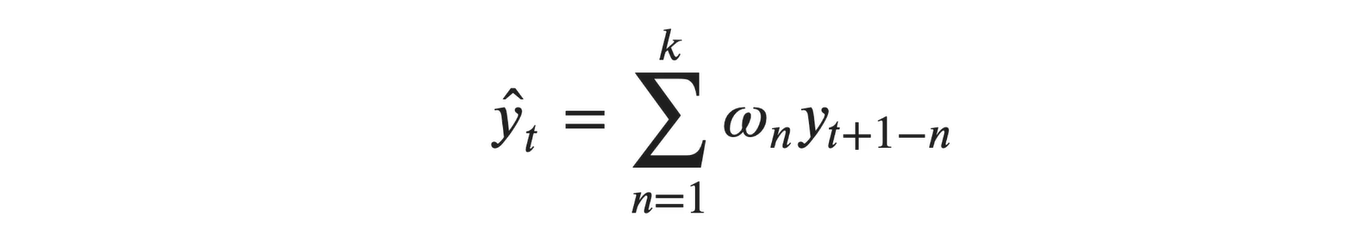

### Comparing weighted average and moving average

I just want to explain this two concept with a basic example. In the below table, there are 4 data points and their values and time information. And let's make some prediction for fifth data points based on both moving and weighted average.

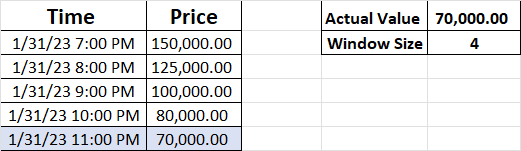

In [33]:
# Define actual value, n_sample(k)
n_samples = 4
actual_value = 70000

In [34]:
# Calculate the moving average
moving_average = (150000 + 125000 + 100000 + 80000) / n_samples
moving_average

113750.0

In [35]:
# Difference between actual value and moving averaege prediction
moving_average - actual_value

43750.0

In [36]:
# Define the weights for weighted average
w1 = 0.1
w2 = 0.1
w3 = 0.2
w4 = 0.6   # sum of all weights should be 1..

In [37]:
# Calculate the weighted average
weighted_average = (w1*150000 + w2*125000 + w3*100000 + w4*80000)
weighted_average

95500.0

In [38]:
# Difference between actual value and weighted averaga
weighted_average - actual_value

25500.0

As you see the results, we made better prediction with weighted average. But not that the all weights of weighted average should be 1. Otherwise our calculation will be wrong.

## Smoothing Methods (Holt-Winters)

Smoothing in the time series analysis is reducing or removing the noise from the data for reveal trendings, patterns or seasonal variations. Main purpose of the smoothing is the make easier to analysis of data and modelling.

In this section we will discover 3 different type of smoothing methods:

1. Single Exponential Smoothing (SES)
2. Double Exponential Smoothing (DES)
3. Trible Exponential Smoothing (TES)

### Single Exponential Smoothing (SES)

Single exponential smoothing, also known as simple exponential smoothing, is to give more weight to recent observations while forecasting future values. This method is useful when dealing with stationary series mean that no trends and seasonality.

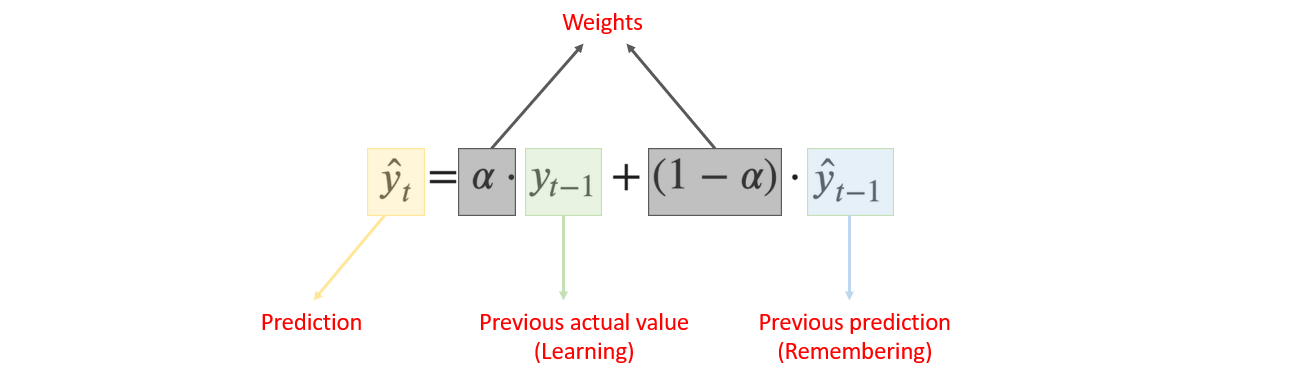

As you see the above formula, there are two main part. First one is the learning part that includes information about actual values and the second part is remembering part that includes the previous predictions. Actually, the most important point in the formula is the weights (a value) because how much weight we want to give each part plays key role to results. Let's look an example for a=0.3 and a=0.05.

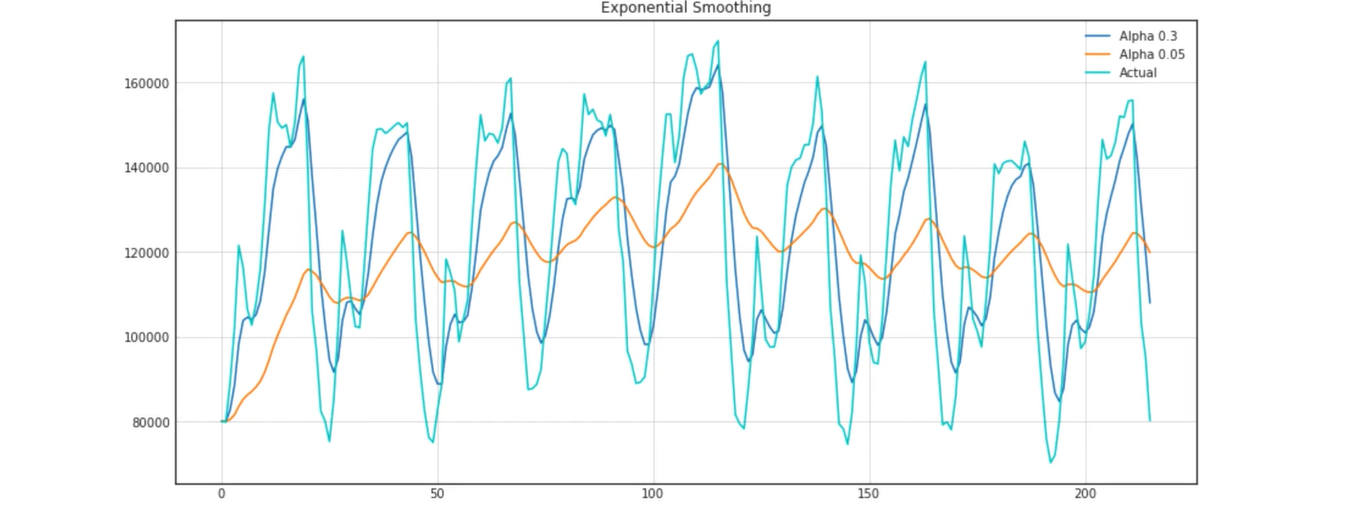

In this example, alpha=0.3 is giving better results. It means that giving more weights to learning part (previous actual values) is more important. However note that it is not a rule and depends on your problem and data.

### Let's make an example with SES

In [39]:
# Import Libraries
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

warnings.filterwarnings('ignore')

Dataset: Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Huwai, USA.

Period of Record: March 1958 - December 2001

In [40]:
# Load data
data = sm.datasets.co2.load_pandas()
y = data.data

# Check the data
y

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


We have weekly data but we want to work monthly data so let's convert weekly data into montly format. To do this we will get the mean of the 4 weeks values for each month.

In [41]:
# Convert weekly data into monthly format
y = y.resample('MS').mean()
y

,co2
1958-03-01,316.100000
1958-04-01,317.200000
1958-05-01,317.433333
1958-06-01,NaN
1958-07-01,315.625000
...,...
2001-08-01,369.425000
2001-09-01,367.880000
2001-10-01,368.050000
2001-11-01,369.375000


In [42]:
# Check the missing values
y.isnull().sum()

co2    5
dtype: int64

There are 5 missing value in the data. We can fill missing row with the its before or after value or average of them for the time series forecasting problems.

In [43]:
# Fill the missing value with before values
y = y.fillna(y.bfill())

In [44]:
# Check the missing values again
y.isnull().sum()

co2    0
dtype: int64

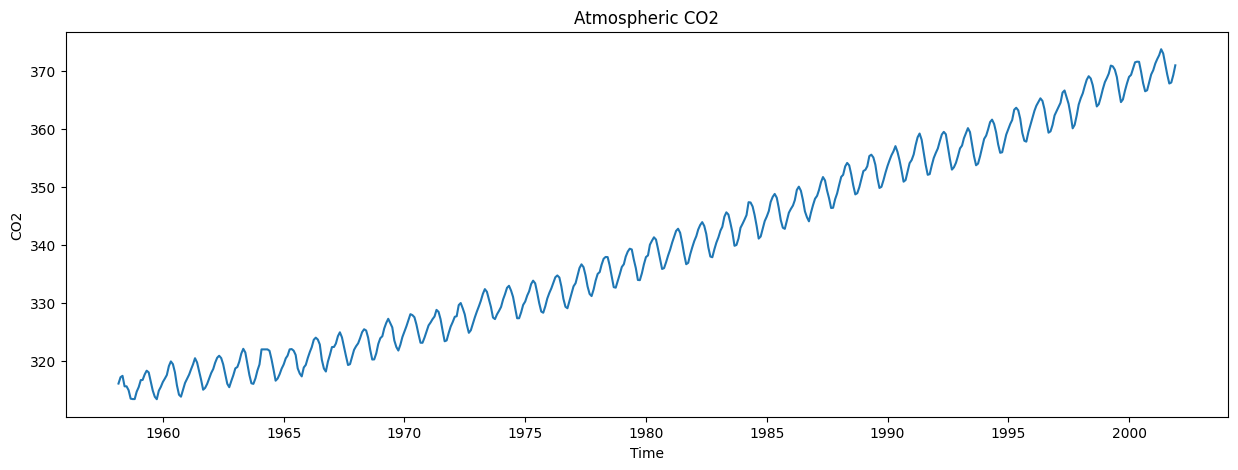

In [45]:
# Plot the data
plt.figure(figsize=(15, 5))
plt.xlabel('Time')
plt.ylabel('CO2')
plt.title('Atmospheric CO2')
plt.plot(y);

At first sight, we can say that there are positive trend and seasonality in the data. Let's start modelling data but before we should split our data into train and test set and fo some structural analysis.

In [46]:
# Train data
train = y[:'1997-12-01']
print(f'Length of training data (total months) is: {len(train)}')

Length of training data (total months) is: 478


In [47]:
# Test data
test = y['1998-01-01':]
print(f'Length of test data (total months) is: {len(test)}')

Length of test data (total months) is: 48


In [48]:
# Structural Analysis - Stationary Test (Dicker-Fuller Test)
def is_stationary(data):
  # H0: Non-stationary
  # H1: Stationary

  p_value = sm.tsa.stattools.adfuller(data)[1]
  if p_value < 0.05:
    print(f'Result: Stationary, p_value: {round(p_value, 3)}')
  else:
    print(f'Result: Non-Stationary, p_value: {round(p_value, 3)}')

# Check the our data stationary
is_stationary(y)

Result: Non-Stationary, p_value: 0.999


In [49]:
# Let's look another function that calculate and plot the time series components and stationary test
def ts_decompose(data, model='additive', stationary=False):
  result = seasonal_decompose(data, model=model)
  fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
  fig.set_figheight(10)
  fig.set_figwidth(15)

  axes[0].set_title('Decomposition for ' + model + ' model')
  axes[0].plot(data, 'k', label='Original ' + model)
  axes[0].legend(loc='upper left')

  axes[1].plot(result.trend, label='Trend')
  axes[1].legend(loc='upper left')

  axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
  axes[2].legend(loc='upper left')

  axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
  axes[3].legend(loc='upper left')
  plt.show()

  if stationary:
    print('\n')
    is_stationary(data)

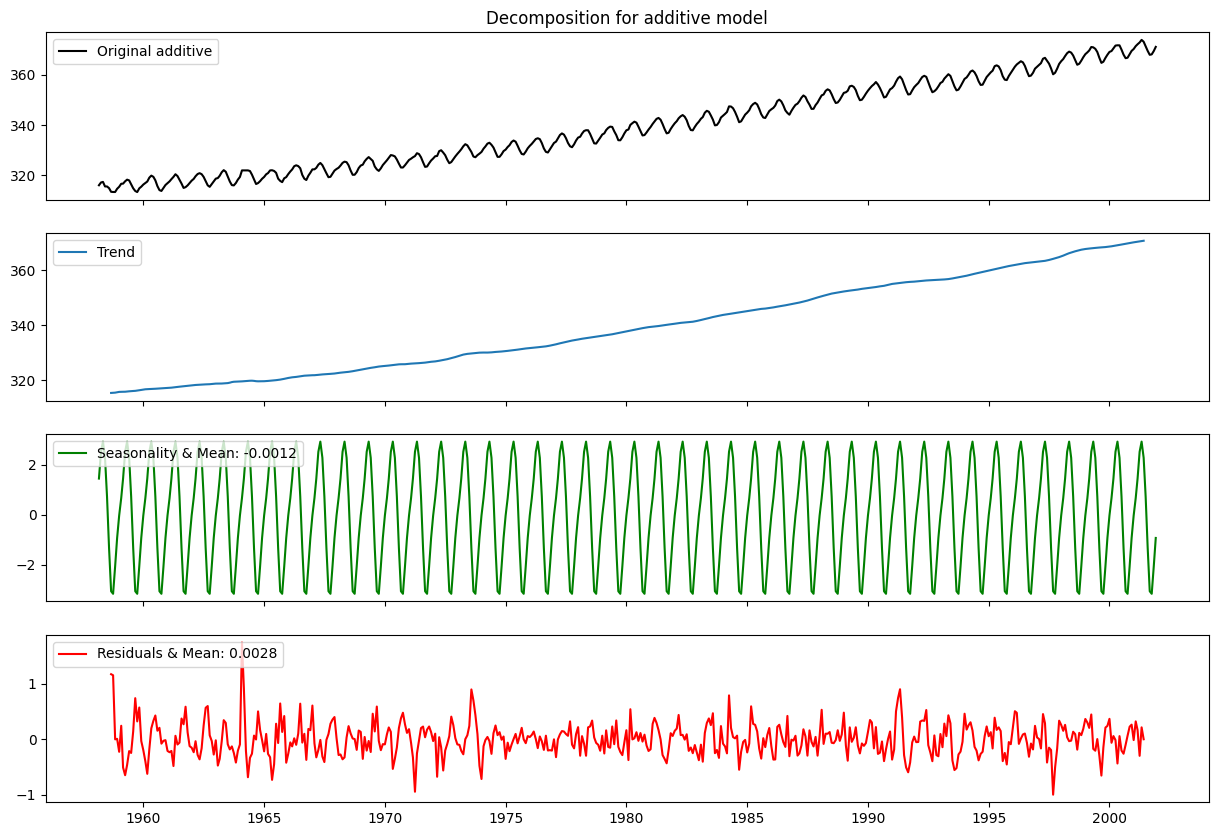



Result: Non-Stationary, p_value: 0.999


In [50]:
# Check the components of data and stationary test
ts_decompose(y, stationary=True)

Now, we divided our data and analyzed data structure so we got these results:

1. No stationary
2. There are positive trend and seasonality

By the way, we wait residuals of time series around zero as our results above.

If we look at the results, we can say that single exponential smoothing method is not useful for our problem. Because SES is conveninet when the data is stationary. Nevertheless, we will use this model and evaluate the results.

In [51]:
# Create single exponential model
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5) # smoothing_level is alpha or also known as weight

In [52]:
# Make some prediction with SES model
y_pred_ses = ses_model.forecast(len(test)) # We have 48 test data so we are waiting for 48 predictions
                                                # Thats why we add length of test data in the forecast as parameter
y_pred_ses

1998-01-01    363.057044
1998-02-01    363.057044
1998-03-01    363.057044
1998-04-01    363.057044
1998-05-01    363.057044
1998-06-01    363.057044
1998-07-01    363.057044
1998-08-01    363.057044
1998-09-01    363.057044
1998-10-01    363.057044
1998-11-01    363.057044
1998-12-01    363.057044
1999-01-01    363.057044
1999-02-01    363.057044
1999-03-01    363.057044
1999-04-01    363.057044
1999-05-01    363.057044
1999-06-01    363.057044
1999-07-01    363.057044
1999-08-01    363.057044
1999-09-01    363.057044
1999-10-01    363.057044
1999-11-01    363.057044
1999-12-01    363.057044
2000-01-01    363.057044
2000-02-01    363.057044
2000-03-01    363.057044
2000-04-01    363.057044
2000-05-01    363.057044
2000-06-01    363.057044
2000-07-01    363.057044
2000-08-01    363.057044
2000-09-01    363.057044
2000-10-01    363.057044
2000-11-01    363.057044
2000-12-01    363.057044
2001-01-01    363.057044
2001-02-01    363.057044
2001-03-01    363.057044
2001-04-01    363.057044


Predictions look very interesting.. As I said before, SES model is useful when there is stationary in the data, that's why all results are same and we made poor predictions.

In [53]:
# Lets evaluate our results with mean absolute error
ses_mae = mean_absolute_error(test, y_pred_ses)
ses_mae

5.706393369643809

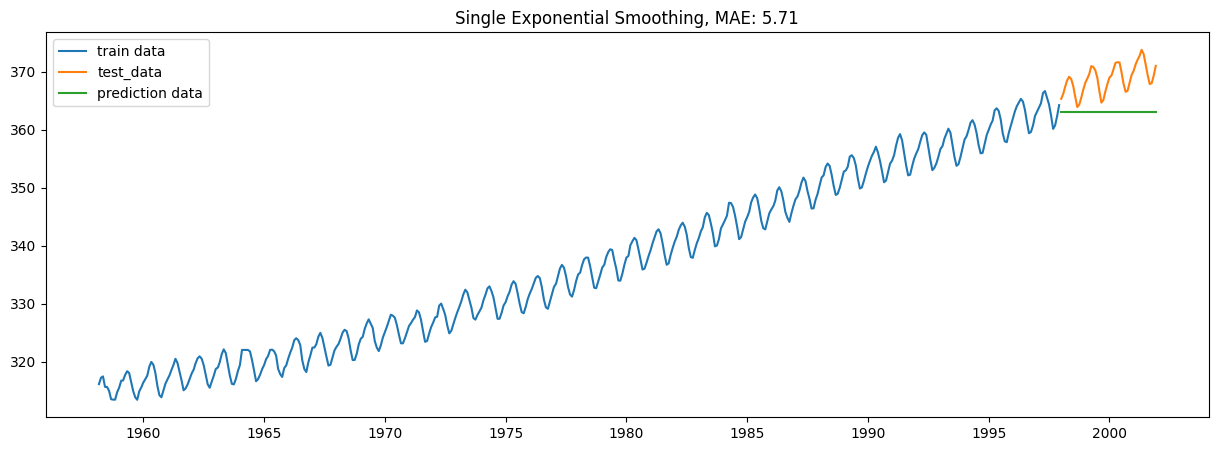

In [65]:
# Create a plot function and plot our results
def plot_predictions(train_data, test_data, y_pred_data, mae):
  plt.figure(figsize=(15, 5))
  plt.plot(train_data, label='train data')
  plt.plot(test_data, label='test_data')
  plt.plot(y_pred_data, label='prediction data')
  plt.title(f'Single Exponential Smoothing, MAE: {round(mae, 2)}')
  plt.legend()
  plt.show()

plot_predictions(train_data=train,
                 test_data=test,
                 y_pred_data=y_pred_ses,
                 mae=ses_mae)

In [55]:
# Let's look the model parameters
ses_model.params

{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 316.1,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

We added alpha=0.5 parameter in the model but is this parameter's value is best? What about the alpha=0.3 or alpha=0.7? To get better results, we should try all the different alpha values. However it is not easy try it manually so we will use hyperparameter optimization. Hyperparameter optimization is best way to find the best parameters for our model and get better results. Let's do that for SES model.

In [56]:
# Create a optization function for single exponential smoothing
def ses_optimizer(train, alphas, len_forecast=48):
  best_alpha, best_mae = None, float('inf')
  for alpha in alphas:
    ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
    y_pred = ses_model.forecast(len_forecast)
    mae = mean_absolute_error(test, y_pred)
    if mae < best_mae:
      best_alpha, best_mae = alpha, mae
    print('alpha:', round(alpha, 2), 'mae:', round(mae, 4))

  print('best_alpha:', round(best_alpha, 2), 'best_mae:', round(best_mae, 4))
  return best_alpha, best_mae

In [57]:
# Create an alpha array for finding best parameters
alphas = np.arange(0.8, 1, 0.01)

In [58]:
# Hyperparameter optmization
best_alpha, best_mae = ses_optimizer(train=train, alphas=alphas, len_forecast=len(test))

alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451


We got the best parameter for alpha. Now, its time to create dinal model with best alpha parameter, plot results and evaluate them.

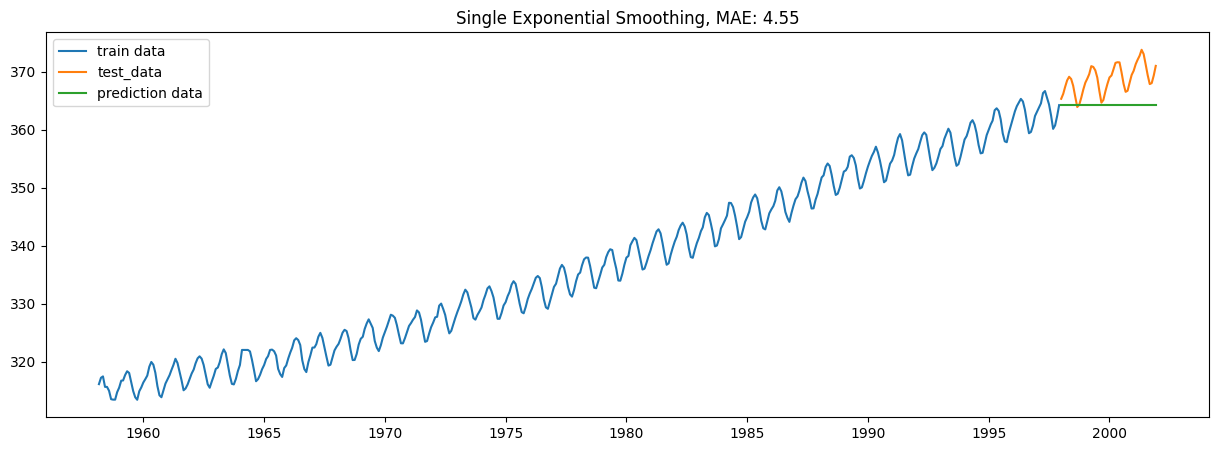

In [59]:
# Final model and evaluate them
final_ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred_ses_final = final_ses_model.forecast(len(test))
final_ses_mae = mean_absolute_error(test, y_pred_ses_final)

# Plot the results
plot_predictions(train_data=train,
                 test_data=test,
                 y_pred_data=y_pred_ses_final,
                 ses_mae=final_ses_mae)

Hmmm. I think we still have poor results because we didn't modelling our data with the suitable model.. Let's continue another section is Double Exponential Smoothing Method.

### Double Exponential Smoothing (DES)

Basically, double exponential smoothing is an extension of single exponential smoothing. DES models consider the trends in addion to SES models and might be very useful when dealing with time series data that exibit both level and trend.

`DES = SES + Trend`

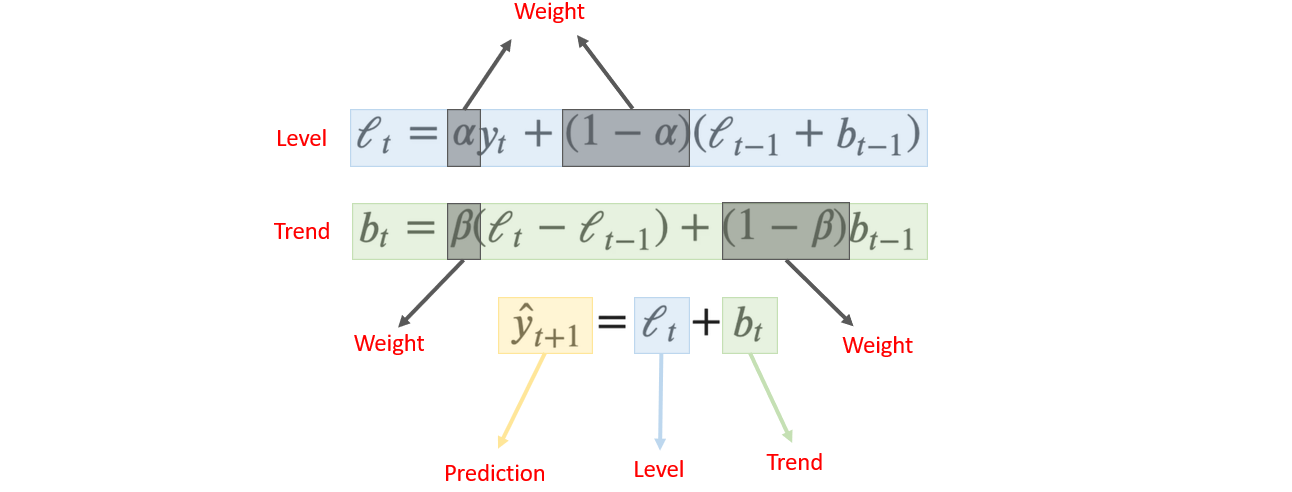

### Let's modelling our data with DES

In [60]:
# Create the double exponential smoothing model
des_model = ExponentialSmoothing(train, trend='add').fit(smoothing_level=0.5,
                                                         smoothing_trend=0.5)

There are two main hyperparameter for our model one of them is smoothing level and the other smoothing trend as you can see from the formula. But what about the `trend='add'`? What is that and what does it mean?

In the time series model basically, there are two main model concepts. These are additive and multiplicative models. Below are the this model concepts:

* Additive model: `y(t) = Level + Trend + Seasonality + Noice`
* Multiplicative model: `y(t) = Level x Trend x Seasonality x Noice`

In an additive model, these components (level, trend, noice, etc) are added together, making it suitable for time series where the effects of trend and seasonality remain relatively constant over time.

In a multiplicative model, these components are multiplied together, making it suitable for time series where the relative importance of trend and seasonality changes with time.

In [62]:
# Make prediction with des model
y_pred_des = des_model.forecast(len(test))
y_pred_des

1998-01-01    362.566380
1998-02-01    363.023579
1998-03-01    363.480777
1998-04-01    363.937976
1998-05-01    364.395175
1998-06-01    364.852373
1998-07-01    365.309572
1998-08-01    365.766771
1998-09-01    366.223970
1998-10-01    366.681168
1998-11-01    367.138367
1998-12-01    367.595566
1999-01-01    368.052765
1999-02-01    368.509963
1999-03-01    368.967162
1999-04-01    369.424361
1999-05-01    369.881560
1999-06-01    370.338758
1999-07-01    370.795957
1999-08-01    371.253156
1999-09-01    371.710355
1999-10-01    372.167553
1999-11-01    372.624752
1999-12-01    373.081951
2000-01-01    373.539150
2000-02-01    373.996348
2000-03-01    374.453547
2000-04-01    374.910746
2000-05-01    375.367944
2000-06-01    375.825143
2000-07-01    376.282342
2000-08-01    376.739541
2000-09-01    377.196739
2000-10-01    377.653938
2000-11-01    378.111137
2000-12-01    378.568336
2001-01-01    379.025534
2001-02-01    379.482733
2001-03-01    379.939932
2001-04-01    380.397131


In [63]:
# Calculate the mean absolute error for des model
des_mae = mean_absolute_error(y_true=test,
                              y_pred=y_pred_des)
des_mae

5.751835862592146

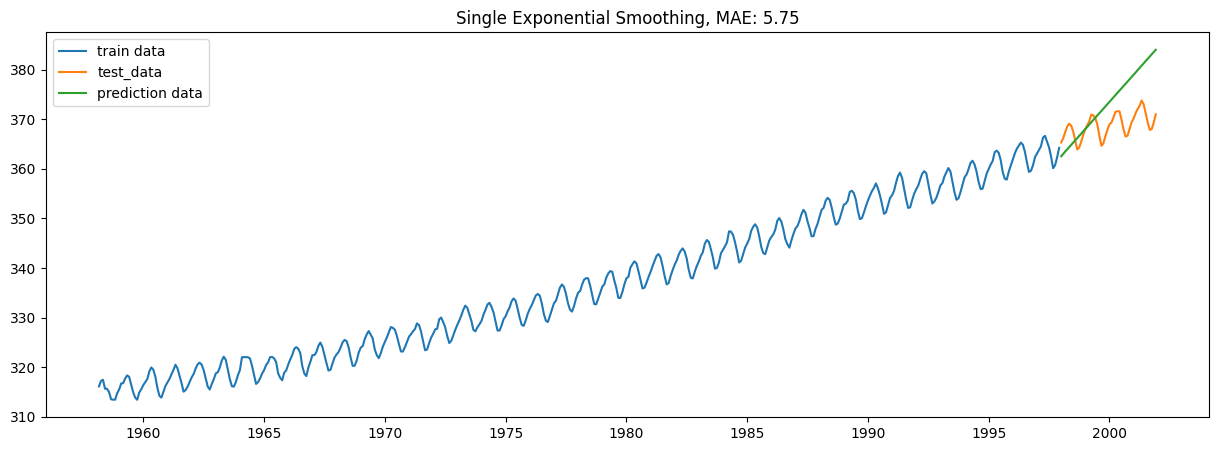

In [67]:
# Plot the prediction
plot_predictions(train_data=train,
                 test_data=test,
                 y_pred_data=y_pred_des,
                 mae=des_mae)

In [68]:
# Create a function for hyperparameter optimization
def des_optimizer(train, alphas, betas, len_forecast=48):
  best_alpha, best_beta, best_mae = None, None, float('inf')
  for alpha in alphas:
    for beta in betas:
      des_model = ExponentialSmoothing(train, trend='add').fit(smoothing_level=alpha,
                                                               smoothing_trend=beta)
      y_pred = des_model.forecast(len_forecast)
      mae = mean_absolute_error(test, y_pred)
      if mae < best_mae:
        best_alpha, best_beta, best_mae = alpha, beta, mae
      print('alpha:', round(alpha, 2), 'beta:', round(beta, 2), 'mae:', round(mae, 4))

  print('best_alpha:', round(best_alpha, 2), 'best_beta:', round(best_beta, 2), 'best_mae:', round(best_mae, 5))
  return best_alpha, best_beta, best_mae

In [71]:
# Create beta and alpha arrays for hyperparemeter optimization
alphas = np.arange(0.01, 1, 0.1)
betas = np.arange(0.01, 1, 0.1)

print('Alphas:', alphas)
print('Betas:', betas)

Alphas: [0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91]
Betas: [0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91]


In [72]:
best_alpha, best_beta, best_mae = des_optimizer(train=train,
                                                alphas=alphas,
                                                betas=betas,
                                                len_forecast=len(test))

alpha: 0.01 beta: 0.01 mae: 2.3849
alpha: 0.01 beta: 0.11 mae: 2.8294
alpha: 0.01 beta: 0.21 mae: 2.744
alpha: 0.01 beta: 0.31 mae: 2.1723
alpha: 0.01 beta: 0.41 mae: 2.8895
alpha: 0.01 beta: 0.51 mae: 2.49
alpha: 0.01 beta: 0.61 mae: 1.8196
alpha: 0.01 beta: 0.71 mae: 1.7411
alpha: 0.01 beta: 0.81 mae: 2.1932
alpha: 0.01 beta: 0.91 mae: 4.8521
alpha: 0.11 beta: 0.01 mae: 2.4334
alpha: 0.11 beta: 0.11 mae: 3.9118
alpha: 0.11 beta: 0.21 mae: 6.0908
alpha: 0.11 beta: 0.31 mae: 7.2434
alpha: 0.11 beta: 0.41 mae: 8.7305
alpha: 0.11 beta: 0.51 mae: 10.3166
alpha: 0.11 beta: 0.61 mae: 12.0066
alpha: 0.11 beta: 0.71 mae: 13.9772
alpha: 0.11 beta: 0.81 mae: 16.4873
alpha: 0.11 beta: 0.91 mae: 19.655
alpha: 0.21 beta: 0.01 mae: 2.8218
alpha: 0.21 beta: 0.11 mae: 5.7217
alpha: 0.21 beta: 0.21 mae: 8.6538
alpha: 0.21 beta: 0.31 mae: 11.7598
alpha: 0.21 beta: 0.41 mae: 15.5277
alpha: 0.21 beta: 0.51 mae: 20.1474
alpha: 0.21 beta: 0.61 mae: 25.5273
alpha: 0.21 beta: 0.71 mae: 31.2781
alpha: 0.21 be

In [73]:
# Create final des model
final_des_model = ExponentialSmoothing(train, trend='add').fit(smoothing_level=best_alpha,
                                                               smoothing_trend=best_beta)

In [74]:
# Make some prediction with final des model
y_pred_des_final = final_des_model.forecast(len(test))

In [75]:
# Lets look at the mean absolute error for des model
final_des_mae = mean_absolute_error(y_true=test,
                                    y_pred=y_pred_des_final)

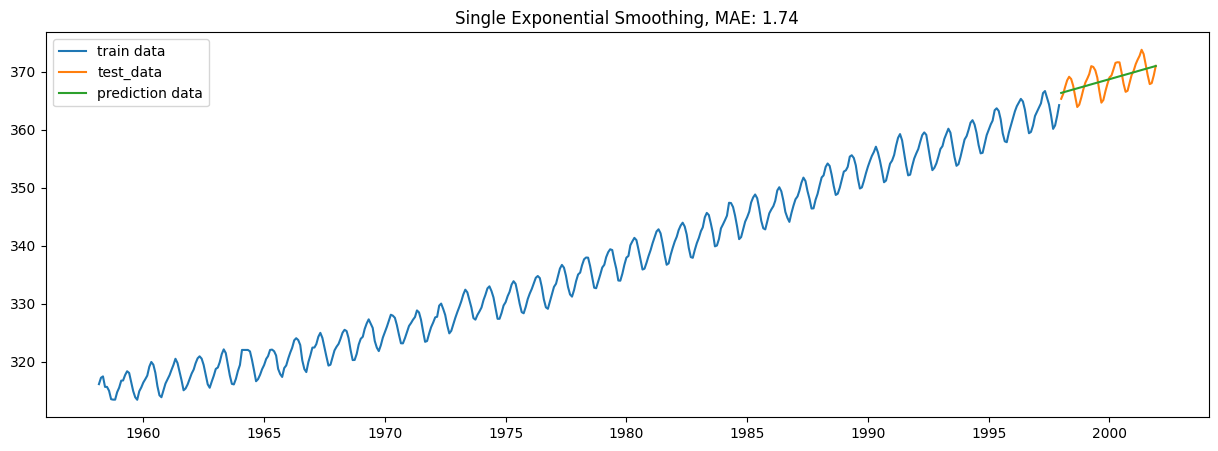

In [76]:
# Lets plot and evaluate our model results
plot_predictions(train_data=train,
                 test_data=test,
                 y_pred_data=y_pred_des_final,
                 mae=final_des_mae)

### Trible Exponential Smoothing (Holt-Winters)

Trible exponential smoothing also known as holt-winters method is an advanced time series forecasting method that extension of the double exponential smoothing. In this method, level(SES), trend and seasonality are using for forecasting. This method is most advanced method in the smoothing techniques and very useful with time series data that exhibit level, trend and seasonality.